In [1]:
import os
os.chdir("..")
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:

import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.feature_extraction.text import TfidfVectorizer
from ai_nlp_bazaar_ticket_classification.utils import plot_confusion_matrix

In [3]:
PATH = os.getcwd()
vocab_size = 15000

In [4]:
train_path = os.path.join(PATH, 'data/data/new_level1_train.txt')
test_path = os.path.join(PATH, 'data/data/new_level1_test.txt')
train = pd.read_csv(train_path, sep=",", header=None)
test = pd.read_csv(test_path, sep=",", header=None)
df = pd.concat((train, test))

In [5]:
df.columns = ['id', 'message', 'subject', 'type']
train.columns = ['id', 'message', 'subject', 'type']
test.columns = ['id', 'message', 'subject', 'type']
train.iloc[0]

id                                                   2814663
message    بازار عزیز ما قریب به یک هفته ست منتظریم که تع...
subject               عدم نمایش نصب فعال پس از سه روز متوالی
type                                          problem_report
Name: 0, dtype: object

In [6]:
df['subject'] = df['subject'].fillna("")
train['subject'] = train['subject'].fillna("")
test['subject'] = test['subject'].fillna("")


In [7]:

from ai_nlp_bazaar_ticket_classification.label_config import *
df['target'] = df['type'].apply(lambda x: FirstLevelIndexes.get(x))
target_list = list(FirstLevelIndexes.keys())

In [8]:
import re
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(r' \1 ', s).split()

In [9]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize(r['message']), tags=[r.type]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize(r['message']), tags=[r.type]), axis=1)
all_tagged = df.apply(
    lambda r: TaggedDocument(words=tokenize(r['message']), tags=[r.type]), axis=1)


In [10]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [11]:
model_dbow = Doc2Vec(dm=0, vector_size=vocab_size, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(all_tagged.values)])

100%|██████████| 15528/15528 [00:00<00:00, 687698.27it/s]


In [12]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_tagged.values)]), total_examples=len(all_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 15528/15528 [00:00<00:00, 927409.01it/s]


CPU times: user 2h 9min 39s, sys: 1h 50min 44s, total: 4h 24s
Wall time: 33min 25s


In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [14]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)


In [15]:

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

/home/faeze/PycharmProjects/ticket_classification/env/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [16]:

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

Testing accuracy 0.3763683193818416
Testing F1 score: 0.2912608489887156


                      precision    recall  f1-score   support

         information       0.38      0.17      0.23       735
      problem_report       0.00      0.00      0.00       279
     question_answer       0.38      0.86      0.52      1098
            requests       0.38      0.10      0.16       979
suggestion_criticism       0.00      0.00      0.00        15

            accuracy                           0.38      3106
           macro avg       0.23      0.23      0.18      3106
        weighted avg       0.34      0.38      0.29      3106



/home/faeze/PycharmProjects/ticket_classification/env/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


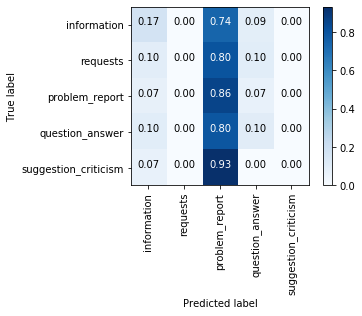

In [17]:
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_list)

####  Distributed Memory

In [12]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=vocab_size, window=10, negative=0, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_tagged.values)])

100%|██████████| 15528/15528 [00:00<00:00, 692090.25it/s]


In [13]:
%%time
for epoch in range(20):
    model_dm.train(utils.shuffle([x for x in tqdm(all_tagged)]), total_examples=len(all_tagged), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 15528/15528 [00:00<00:00, 502129.07it/s]


CPU times: user 3h 53min 26s, sys: 7h 14min 40s, total: 11h 8min 6s
Wall time: 3h 16min 25s


In [14]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [16]:
y_train, X_train = vec_for_learning(model_dm, train_tagged)
y_test, X_test = vec_for_learning(model_dm, test_tagged)


In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_list)

#### concat model_elbow and model_dm

In [ ]:
train_tagged

In [ ]:
def vec_for_learning(model1, model2, tagged_docs):
    sents = tagged_docs.values
    vector1 = np.array([model1.infer_vector(doc.words, steps=20) for doc in sents])
    vector2 = np.array([model2.infer_vector(doc.words, steps=20) for doc in sents])
    print(vector1.shape, vector2.shape)
#     regressors = np.array([np.append(model1.infer_vector(doc, steps=20),model2.infer_vector(doc, steps=20)) for doc in sents])
    regressors = np.concatenate((vector1, vector2), axis=1)
    print(regressors.shape)
    targets = np.array([doc.tags[0] for doc in sents])
    return targets, regressors

In [ ]:

y_train, X_train = vec_for_learning(model_dbow, model_dm, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, model_dm, test_tagged)

In [ ]:

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
print(metrics.classification_report(y_test, y_pred))
metrics.confusion_matrix(y_test, y_pred)

In [ ]:
df

### Word 2 Vec

In [ ]:

from gensim.models import phrases, word2vec

In [ ]:
df['tokenized'] = df['message'].apply(lambda row: tokenize(row))


In [ ]:
bigrams = phrases.Phrases(df['tokenized'])

In [ ]:
words = df['tokenized'].values

In [ ]:
w2v = word2vec.Word2Vec(bigrams[words], size=vocab_size, window=5, min_count=1, workers=4)

In [ ]:
w2v.wv.vocab

In [ ]:
def document_vector(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = np.array([word for word in doc if word in w2v.wv.vocab])
    
    return np.mean(w2v[doc], axis=0)

In [ ]:
train['doc_vector'] = train.message.apply(document_vector)
test['doc_vector'] = test.message.apply(document_vector)

In [ ]:
X_train = np.stack(train['doc_vector'], axis=0)
X_test = np.stack(test['doc_vector'], axis=0)

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')

logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_list)

### tfidf & model_em

In [12]:
# from gensim.test.utils import get_tmpfile
# fname = get_tmpfile('level1_doc2vec_model')
# model_dm.save(PATH+fname)
model_dm = Doc2Vec.load(PATH+'/level1_doc2vec_model.wv.vectors.npy')

In [13]:
vect = TfidfVectorizer(strip_accents='unicode', tokenizer=None, ngram_range=(1, 3), max_df=0.75, min_df=3, sublinear_tf=True)

In [14]:
tfidf_df = vect.fit_transform(df['message'].values)

In [15]:
def vec_for_learning(model1, tfidf_model, tagged_docs, docs):
    sents = tagged_docs.values
    vector1 = np.array([model1.infer_vector(doc.words, steps=20) for doc in sents])
    vector2 = tfidf_model.transform(docs).toarray()
#     print( vector1.shape, vector2.shape )
#     regressors = np.array([np.append(model1.infer_vector(doc, steps=20),model2.infer_vector(doc, steps=20)) for doc in sents])
    regressors = np.concatenate((vector1, vector2), axis=1)
#     print(regressors.shape)
    targets = np.array([doc.tags[0] for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dm, vect, train_tagged, train['message'].values)
y_test, X_test = vec_for_learning(model_dm, vect, test_tagged, test['message'].values)


In [ ]:
logreg = LogisticRegression(C=22, class_weight='balanced', max_iter=1000, multi_class='multinomial')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [ ]:
# svm_model = SVC(C=10, kernel='rbf', gamma='scale', class_weight='balanced', probability=True)
# svm_model.fit(X_train, y_train)
# y_pred = svm_model.predict(X_test)

In [ ]:

from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

In [ ]:
print(metrics.classification_report(y_test, y_pred))
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_list)

In [ ]:

input_sample = ['با سلام  یکت نمیتوانم بفرستم و لینک ها هم درست کار نمی کنند']
for i in range(10):
    x = np.array(input_sample)
    t = pd.DataFrame(x)
    
    t_tagged = t[0].apply(lambda r: r.split())
    _, v = vec_for_learning(model_dm, vect, t_tagged, t[0].values)
    p = logreg.predict(v)
    c = np.max(logreg.predict_proba(v), axis=1)
    print(p, c)

In [ ]:
# import pickle
# model_path='data/model/level2_model_LR.pkl'
# vect_path='data/model/level2_vect_tfidf.pkl'
# vect_doc2vec_path='data/model/level2_vect_doc2vec.pkl'

# base_path = PATH #os.path.dirname(os.path.abspath(__file__))

# with open(os.path.join(base_path, model_path), 'wb') as file:
#     pickle.dump(logreg, file)
# with open(os.path.join(base_path, vect_path), 'wb') as file:
#     pickle.dump(vect, file)
# with open(os.path.join(base_path, vect_doc2vec_path), 'wb') as file:
#     pickle.dump(model_dm, file)


In [ ]:
df = pd.DataFrame(y_train)

from ai_nlp_bazaar_ticket_classification.label_config import *
df[1] = df[0].apply(lambda x: FirstLevelIndexes.get(x))
np.unique(df[1])

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, random_state=7, angle=.99, init='pca')
reduced_features = tsne.fit_transform(X_train)
# plt.scatter(reduced_features[:,0], reduced_features[:,1], c=df[1].values)


In [ ]:
data = [reduced_features[np.where(df[1] == i)] for i in range(5)]
colors = ["red", "blue", "brown", "yellow", "green"]
groups = list(FirstLevelIndexes.keys())

# Create plot
fig, ax = plt.subplots()

for data, color, group in zip(data, colors, groups):
    x = data[:, 0]
    y = data[:, 1]
    ax.scatter(x, y, alpha=0.8, c=color, edgecolors='none', s=30, label=group)

plt.title('Matplot scatter plot')
plt.legend(loc=2)
plt.show()

In [ ]:
preds = logreg.predict(X_test)
confs = np.max(logreg.predict_proba(X_test), axis=1)
preds_df = pd.DataFrame(preds)
if isinstance(preds_df[0][0], int):
    preds_df[0] = preds_df[0].apply(lambda x: index2label(x))
result = np.stack((preds_df[0].values, confs), axis=1)

In [ ]:
test[3] = preds_df[0]
np.savetxt(os.path.join(PATH, 'data/data/level1_error.csv'), test[preds!=y_test], fmt="%s", delimiter=",")

In [ ]:
test